In [ ]:
# Configure the parent path to be the proj folder
import sys, os, torch, time
sys.path.append('../../')

# Import the model classes
from rwkv_block.v7_goose.model.rwkv7_goose_model import RWKV7GooseModel
from rwkv_block.v7_goose.model.rwkv7_goose_config_map import RWKV7GooseConfigMap

# File to load
MODEL_FILENAME="v7-1B4.pth"

# Run device, and run dtype to use
RUN_DEVICE="cpu"
RUN_DTYPE=torch.bfloat16

# Check for cuda device
if torch.cuda.is_available():
    RUN_DEVICE="cuda:0"

# Check if the reference weights exists
assert os.path.exists(f"./.model/{MODEL_FILENAME}"), "The reference weights does not exist. Please download it first (00-model-download.ipynb)"

# Loads the model weights
model_weight = torch.load(f"./.model/{MODEL_FILENAME}", map_location='cpu', weights_only=True, mmap=True)

# Model filename
print(f"### Model filename: {MODEL_FILENAME}")

# Lets get the n_dim, and setup the test module
n_dim = model_weight['emb.weight'].shape[1]
print(f"### Model n_dim: {n_dim}")

# # List the model weights keys, and their shapes
# print(f"### model weights keys:")
# for key in model_weight:
#     print(f"{key}: {model_weight[key].shape} - {model_weight[key].dtype}")

ModuleNotFoundError: No module named 'rwkv.v7_goose'

---

## Validate Pytorch VS Triton Kernel

In [2]:
BATCH_SIZE=1
TEST_LOOP=1
TEST_COUNT=1

# Get the pytorch model
py_model_config = RWKV7GooseConfigMap.from_model_state_dict(model_weight, device=RUN_DEVICE, dtype=RUN_DTYPE, tmix_backend="pytorch")
py_model = RWKV7GooseModel(py_model_config)
py_model.load_state_dict(model_weight)
print("### Pytorch Model Config:", py_model_config)

# Get the triton model
tr_model_config = RWKV7GooseConfigMap.from_model_state_dict(model_weight, device=RUN_DEVICE, dtype=RUN_DTYPE, tmix_backend="triton")
tr_model = RWKV7GooseModel(tr_model_config)
tr_model.load_state_dict(model_weight)
print("### Triton Model Config:", tr_model_config)

### Pytorch Model Config: RWKV7GooseConfigMap(n_layer=24, n_dim=2048, head_size=64, head_size_divisor=8, dropout_rate=0.0, tmix_backend='pytorch', layer_id=None, device='cuda:0', dtype=torch.bfloat16, n_dim_ffn=8192, n_dim_att=2048, n_vocab=50304, init_state_wkv=False)
### Triton Model Config: RWKV7GooseConfigMap(n_layer=24, n_dim=2048, head_size=64, head_size_divisor=8, dropout_rate=0.0, tmix_backend='triton', layer_id=None, device='cuda:0', dtype=torch.bfloat16, n_dim_ffn=8192, n_dim_att=2048, n_vocab=50304, init_state_wkv=False)


In [5]:
# Lets prepare the states accordingly
in_state = py_model.get_init_state(BATCH_SIZE)
x_tokens = torch.zeros(BATCH_SIZE, 1, device=py_model.emb.weight.device, dtype=torch.int)

# Lets get the respective outputs

with torch.inference_mode():
    # Pytorch
    py_out_logit, py_out_state = py_model.forward_with_reduce_compile(x_tokens, in_state)
    # py_out_logit = torch.nn.functional.log_softmax(py_out_logit, dim=-1)
    print(f"### Pytorch Output x: {py_out_logit.shape}")

    # Triton
    tr_out_logit, tr_out_state = tr_model.forward_with_reduce_compile(x_tokens, in_state)
    # tr_out_logit = torch.nn.functional.log_softmax(tr_out_logit, dim=-1)
    print(f"### Triton Output x: {py_out_logit.shape}")

    # Compute the delta logit
    delta_tr_logit = (py_out_logit - tr_out_logit).view(128,-1).float().cpu().numpy()
    delta_tr_logit_abs_max = max(abs(delta_tr_logit.max()), abs(delta_tr_logit.min()))
    # Log the delta logit shape
    print(f"### Delta Logit (Shape: {delta_tr_logit.shape}, max:", delta_tr_logit.max(), ", min:", delta_tr_logit.min(), ")")

### Pytorch Output x: torch.Size([1, 1, 50304])
### Triton Output x: torch.Size([1, 1, 50304])
### Delta Logit (Shape: (128, 393), max: 0.8125 , min: -2.25 )


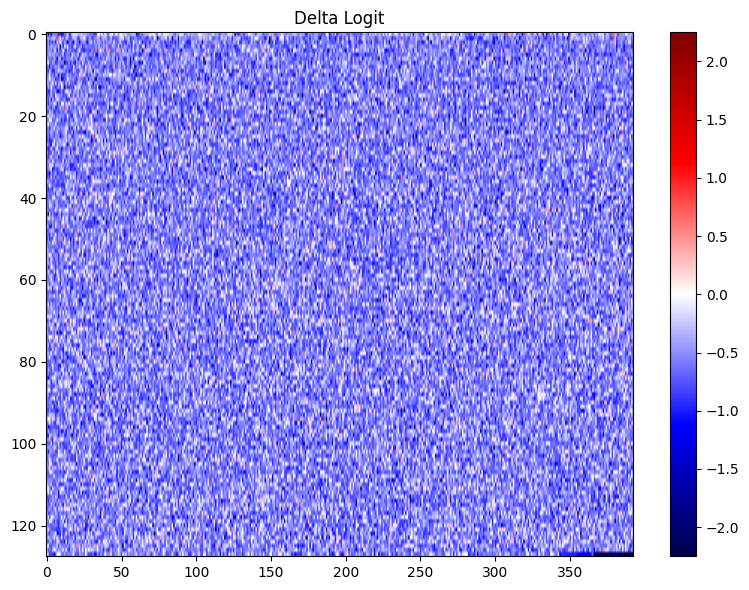

In [6]:
# Plot the delta logit
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_logit, cmap='seismic', aspect='auto')
im.set_clim(-delta_tr_logit_abs_max, delta_tr_logit_abs_max)
ax.set_title('Delta Logit (pytorch -> triton)')
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

---

## Validate pytorch vs rwkv-lib

In [ ]:
!pip3 install rwkv sympy==1.13.3

In [ ]:
os.environ["RWKV_V7_ON"] = '1' # ==> enable RWKV-7 mode
os.environ['RWKV_JIT_ON'] = '1' # '1' for better speed
os.environ["RWKV_CUDA_ON"] = '0' # '1' to compile CUDA kernel (10x faster), requires c++ compiler & cuda libraries

from rwkv.model import RWKV
from rwkv.utils import PIPELINE, PIPELINE_ARGS

# Load the model
ref_model = RWKV(model=f"./.model/{MODEL_FILENAME}", strategy="cuda bf16")
# pipeline = PIPELINE(model, "rwkv_vocab_v20230424") # for "world" models

# Get the reference output
ref_out_logit, ref_out_state = ref_model.forward([0], None)

# Get the delta pytorch / reference output
delta_ref_py_out_logit = (ref_out_logit[0] - py_out_logit).view(128,-1).float().cpu().numpy()
delta_ref_py_out_logit_abs_max = np.abs(delta_ref_py_out_logit).max()
# Log the delta shape and max value
print(f"### delta_ref_py_out_logit.shape: {delta_ref_py_out_logit.shape}, max: {delta_ref_py_out_logit.max()}, min: {delta_ref_py_out_logit.min()}")

In [ ]:
# Plot the delta logit
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_ref_py_out_logit, cmap='seismic', aspect='auto')
im.set_clim(-delta_ref_py_out_logit_abs_max, delta_ref_py_out_logit_abs_max)
ax.set_title('Delta Logit (reference -> pytorch)')
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()